<a href="https://colab.research.google.com/github/AdrianKopperud/automatedfeatureengineering/blob/main/Feature_Tool_Dataset_Master_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U pandas-profiling
!pip install featuretools

### Import functions

In [ ]:
# Import
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import datetime as dt
import datetime
import autonormalize as an
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
import featuretools.variable_types as vtypes
import featuretools as ft
import gc
import re
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from google.colab import drive
import math
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 3000)
pd.set_option('display.max_rows', 3000)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Function to calculate Precision and Recall

def calc_precision_recall(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and test_y[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall


from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = XGBClassifier(num_boost_round=100, n_estimators = 240, tree_method='gpu_hist', )
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

def check_missing(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    col = missing_table.rename(columns = {0 : 'Num', 1 : 'Rate'})
    return col

def plot_missing_pct(df, features, feature_name):
    '''this function draw bar plot of missing value percentage '''
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    
    ax.bar(features, df[features].isnull().mean())
    ax.set_ylim(0,1)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('% missing data')
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    plt.title('Percentage of missing values of {}'.format(feature_name))
    plt.show()
    
def pca_transform(df, features, explained_var_ratio = 0.95, prefix = 'PCA_'):
    '''this function conducts pca transformation to reduce dimension'''
    # drop na cols where missing value % > 0.9
    filtered_features = df[features].isnull().mean().where(lambda x: x<0.9).dropna().index.values
    
    # fill na
    df.loc[:, filtered_features] = df[filtered_features].fillna(-1)
    
    # scale
    scaler = MinMaxScaler()
    scaledArr = scaler.fit_transform(df[filtered_features])
    scaledDF = pd.DataFrame(scaledArr, index=df.index, columns= filtered_features)
    
    # PCA
    pca = PCA(explained_var_ratio, random_state = 0)
    principalComponents = pca.fit_transform(scaledDF)
    principalDF = pd.DataFrame(principalComponents, columns = [prefix+str(x) for x in range(1, principalComponents.shape[1]+1)])
    
    df.drop(features, axis=1, inplace=True)
    df = pd.concat([df, principalDF], axis=1)
    
    return df, scaler, pca

def scree_plot(pca):
    '''this function creates a scree plot associated with the principal components.'''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.show()
    
    cumvals = np.cumsum(pca.explained_variance_ratio_)
    print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(24,24))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

## Function to reduce the DF size
def memory_reducer(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
def conf_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

### 1 Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# import data

id = pd.read_csv("/content/drive/MyDrive/Thesis/Data/ID.csv")
tran = pd.read_csv("/content/drive/MyDrive/Thesis/Data/Transaction.csv")

# Remove vesta features V_xxxx
tran = tran.loc[:,~tran.columns.str.startswith('V')]

# Merge the classes into shared df dataframe
df = pd.merge(tran, id, how="outer", on=["TransactionID"])

del tran
del id

### 2 Pre-processing

Create categories for each e-mail provider and cluster e-mail within the company provider. As such we could reduce the number of categories from 60 to a few. __Furthermore did I split up the .com, .us and so on into suffix, not sure if that may be future engineering since the data in the categorical variable are split into two different new variables.__

#### 2.1 Catagorical features

##### 2.1.1 P_emaildomain and R_emaildomain

In [ ]:
# email features: P_emaildomain, R_emaildomain
# email map
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# fill na
df.loc[:, ['P_emaildomain', 'R_emaildomain']] = df[['P_emaildomain', 'R_emaildomain']].fillna('None')

# clean email domains
df = df.assign(P_emaildomain_bin = df['P_emaildomain'].map(emails),
          P_emaildomain_suffix = df['P_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
          R_emaildomain_bin = df['R_emaildomain'].map(emails),
          R_emaildomain_suffix = df['R_emaildomain'].map(lambda x: str(x).split('.')[-1]).map(lambda x: 'us' if str(x) in us_emails else x),
        )

df.loc[:, ['P_emaildomain_bin', 'R_emaildomain_bin']] = df[['P_emaildomain_bin', 'R_emaildomain_bin']].fillna('None')

df.drop(['P_emaildomain', 'R_emaildomain'], axis=1, inplace=True)

NameError: ignored

##### 2.1.2 Device features, DeviceInfo and DeviceType

For DeviceType, DeviceInfo and other id_xx variables with device info regarding screen size, phone producer and browser, did I cluster the different brands of same name into one brand. This reduces the number of categories. Furthermore, was the NAN observations filled with None. 

In [ ]:
# deveice features: DeviceInfo, DeviceType
# device map
devices = {'SM': 'Samsung', 'SAMSUNG': 'Samsung', 'GT-': 'Samsung', 'Moto G': 'Motorola',
           'Moto': 'Motorola', 'moto': 'Motorola', 'LG-': 'LG', 'VS\d{3}': 'LG', 'LG\w{2}\d{3}': 'LG', 'rv': 'RV', 'HUAWEI': 'Huawei',
           'ALE-':'Huawei', '-L':'Huawei', 'hi6210sft': 'Huawei', 'CHC-U03': 'Huawei', 'Blade': 'ZTE', 'Z\d{3}': 'ZTE', 'BLADE': 'ZTE', 'ZTE':'ZTE', 
           'Linux': 'Linux', 'XT': 'Sony', 'F\d{4}': 'Sony', 'E\d{4}': 'Sony', 'G\d{4}': 'Sony', 'HTC': 'HTC', 'ASUS': 'Asus',
           'Pixel': 'Pixel', 'Lenovo': 'Lenovo', 'Windows': 'Windows', 'Redmi': 'Redmi', 'Ilium': 'Ilium', 'ILIUM': 'Ilium',
           'Hisense': 'Hisense', 'KF': 'Amazon', 'Android': 'Android', '\d{4}A': 'Alcatel', '\d{4}W': 'Alcatel', '\d{4}M': 'Alcatel', 
           'Alcatel': 'Alcatel', 'ALCATEL':'Alcatel', '\d{4}G': 'Mozilla', 'M4': 'M4', 'TA-': 'Nokia', 'NOKIA': 'Nokia', 'Nexus':'Nexus', 'BLU':'BLU'}

# devices_list = df.loc[:,'device_name'].value_counts().where(lambda x : x>80).dropna().index.values

devices_list = ['None', 'Windows', 'iOS Device', 'MacOS', 'Samsung', 'Trident', 'RV',
               'Motorola', 'LG', 'Huawei', 'Sony', 'ZTE', 'HTC', 'Alcatel', 'Lenovo',
               'Ilium', 'Pixel', 'Hisense', 'Amazon', 'Mozilla', 'M4', 'Redmi',
               'Nokia', 'Linux', 'Nexus', 'Android']

# clean device name
df.loc[:,'DeviceName'] = df['DeviceInfo'].str.split('/').str[0].fillna('None')
for k,v in devices.items():
    df.loc[df['DeviceName'].str.contains(k, na=False), 'DeviceName'] = v
df.loc[~df['DeviceName'].isin(devices_list), 'DeviceName'] = 'Others'

# remove DeviceInfo
df.drop(['DeviceInfo'], axis=1, inplace=True)

# DeviceType - fillna
df.loc[:,'DeviceType'] = df['DeviceType'].fillna('None')

NameError: ignored

##### 2.1.3 Other categorical features, address and card

Further I converted address and card variables from float to categorical/object as they were specified by VESTA in (https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) to be categorical. Hence, should not be treated as numerical values as they have another meaning. Further was NAN values filled with NONE to remove the missing values and use a common new category for all missing values to keep the pattern in the data. 

In [ ]:
# other categorical features (address, card, M features)
addr_features = df.columns[df.columns.str.contains('addr')].values.tolist()
card_features = df.columns[df.columns.str.contains('card')].values.tolist()
m_features = df.columns[df.columns.str.contains('M\d+')].values.tolist()

# int to float
features_to_int = df[addr_features+card_features].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, features_to_int] = df.loc[:, features_to_int].astype('Int64')

# int to str
df.loc[:, addr_features+card_features] = df.loc[:, addr_features+card_features].astype(str)

# fill na
df.loc[:, addr_features+card_features+m_features] = df[addr_features+card_features+m_features].fillna('None')

# clean card type
df['card6'] = df['card6'].map(lambda x: 'None' if x not in ['debit', 'credit', 'None'] else x)

##### 2.1.4 ID_features

Clean the categorical ID_xx variables that goes from ID_12 until ID_38 + "DeviceInfo" and "DeviceType". We convert the categorical ID_xx from float to object/category as the numbers in the variables which are categorical (specified by VESTA) do not have the same numeric meaning as true numeric float variables.__Furthermore, do we split the id_01 - id_11 into its own category which we will treat accordingly in the numerical cleaning part for id_xx features!__

In [ ]:
id_features = df.columns[df.columns.str.contains('id_\d+')]
cat_id_features = ['id_'+str(x).zfill(2) for x in range(12, 38+1)]
num_id_features = ['id_'+str(x).zfill(2) for x in range(1, 12)]

In [ ]:
# missing value check
num_check_df = pd.DataFrame({'Missing Percentage': np.round(df[num_id_features].isnull().mean()*100), 
              'Zero Percentage': np.round((df[num_id_features]==0).mean()*100),
              'Total Percentage': np.round((df[num_id_features].isnull()|(df[num_id_features]==0)).mean()*100)})\
            .sort_values('Total Percentage', ascending=False)
    
cat_check_df = pd.DataFrame({'Missing Percentage': np.round(df[cat_id_features].isnull().mean()*100),
                             'Nunique': df[cat_id_features].nunique()})\
            .sort_values('Missing Percentage', ascending=False)
    
# drop missing + zero values >= 99%
num_id_features_todrop = num_check_df[num_check_df['Total Percentage'] >= 99].index.values.tolist()
num_id_features_tokeep = num_check_df[num_check_df['Total Percentage'] < 99].index.values.tolist()
df.drop(num_id_features_todrop, axis=1, inplace=True)

cat_id_features_todrop = cat_check_df[cat_check_df['Missing Percentage'] >= 99].index.values.tolist()
cat_id_features_tokeep = cat_check_df[cat_check_df['Missing Percentage'] < 99].index.values.tolist()
df.drop(cat_id_features_todrop, axis=1, inplace=True)

In [ ]:
# int to float
cat_id_features_to_int = df[cat_id_features_tokeep].dtypes.where(lambda x: x == 'float64').dropna().index
df.loc[:, cat_id_features_to_int] = df.loc[:, cat_id_features_to_int].astype('Int64')

# int to str
df.loc[:, cat_id_features_to_int] = df.loc[:, cat_id_features_to_int].astype(str)

# fill na with None
df[cat_id_features_tokeep] = df[cat_id_features_tokeep].fillna('None')

# id - system
df['sys_id_30'] = df['id_30'].str.split(' ').str[0]
sys_list = ['Windows', 'iOS', 'Mac', 'Android', 'Linux', 'None']
df['sys_id_30'] = np.where(df['sys_id_30'].isin(sys_list), df['sys_id_30'], 'None')

# id - browser
browsers = {'safari': 'safari', 'chrome': 'chrome', 'samsung': 'samsung', 'Samsung': 'samsung', 'edge': 'edge', 
 'firefox': 'firefox', 'ie':'ie', 'google':'google', 'other':'others', 'None':'None'}
browsers_list = ['chrome','safari','ie','firefox','edge','samsung','None']
for k,v in browsers.items():
    df.loc[df['id_31'].str.contains(k, na=False), 'browser_id_31'] = v
df.loc[~df['browser_id_31'].isin(browsers_list), 'browser_id_31'] = 'others'

# id - screen
df.loc[df['id_33']=='0x0', 'id_33'] = 'None'
screen_height = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[1].astype(int)
bins = [0, 900, 1500, np.inf]
screen_height_cate = pd.cut(screen_height, bins, labels=['s', 'm', 'l'])
screen_width = df.loc[df['id_33']!='None', 'id_33'].str.split('x').str[0].astype(int)
bins = [0, 1200, 2000, np.inf]
screen_width_cate = pd.cut(screen_width, bins, labels=['s', 'm', 'l'])

screen = screen_width_cate.astype(str) + 'x' + screen_height_cate.astype(str)
df.loc[df['id_33']!='None', 'screen_id_33'] = screen
df.loc[df['id_33']=='None', 'screen_id_33'] = 'None'

# drop id 30, 31, 33
df.drop(['id_30','id_31','id_33'], axis=1, inplace=True)
cat_id_features_tokeep.remove('id_30')
cat_id_features_tokeep.remove('id_31')
cat_id_features_tokeep.remove('id_33')

# Append categorical to list
cat_id_features_tokeep.extend(['sys_id_30', 'browser_id_31', 'screen_id_33'])

gc.collect()

##### 2.1.5 Label encoder

In [ ]:
# Label Encoding
category = []
for f in df.drop('isFraud', axis=1).columns:
    if df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        category.append(f)
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

#### 2.2 Numerical features

##### 2.2.1 Transaction features

AxesSubplot(0.125,0.125;0.775x0.755)


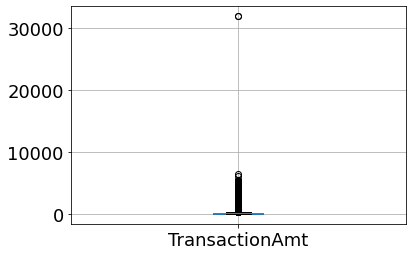

In [ ]:
# Vizualize outliers thorugh boxplot
print(df.boxplot('TransactionAmt'))

In [ ]:
df.drop(df.loc[df['TransactionAmt']>15000].index, inplace=True)

##### 2.2.2 dist features

In [ ]:
# Dist features
pd.DataFrame(np.round(df[['dist1', 'dist2']].isnull().mean()*100), columns = ['Missing Percentage'])

# drop dist 2
df.drop(['dist2'], axis=1, inplace=True)

##### 2.2.4 Impute numeric NAN

In [ ]:
df = df.fillna(-999)

##### 2.2.3 Adding start date of TransactionDT

In [ ]:
START_DATE = '2017-12-01'
startdate = dt.datetime.strptime(START_DATE, '%Y-%m-%d')

df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + dt.timedelta(seconds = x)))

In [ ]:
memory_reducer(df)

Mem. usage decreased to 81.10 Mb (78.6% reduction)


#### 2.3.0 Split Train/Test





In [ ]:
# Isolate target variable
y = df.pop('isFraud')
X = df.copy(deep=True)

In [ ]:
# Test = 70%, Validation = 14%, Test = 16%
# Split is done by 3 different time sequences. 

train_length = 472432
test_length = 590540

train_X, train_y = X.iloc[:train_length], y.iloc[:train_length]
test_X, test_y = X.iloc[train_length:test_length], y.iloc[train_length:test_length]

train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

In [ ]:
memory_reducer(train_X)
memory_reducer(test_X)

Mem. usage decreased to 60.82 Mb (0.0% reduction)
Mem. usage decreased to 15.21 Mb (0.0% reduction)


#### 2.4 Feature Tool

##### 2.4.1 Specify dtype

In [ ]:
### Add right categorical dtype for variabels in feature tool ###

# Specify main table

variable_type_transaction = {'TransactionID': vtypes.Categorical,
      'addr1': vtypes.Categorical,
      'addr2': vtypes.Categorical,
      'ProductCD': vtypes.Categorical,
      'P_emaildomain_bin': vtypes.Categorical,
      'R_emaildomain_bin': vtypes.Categorical,
      'P_emaildomain_suffix': vtypes.Categorical,
      'R_emaildomain_suffix': vtypes.Categorical,
      'TransactionDT': vtypes.DatetimeTimeIndex,
      'id_12': vtypes.Categorical,
      'id_13': vtypes.Categorical,
      'id_14': vtypes.Categorical,
      'id_15': vtypes.Categorical,
      'id_16': vtypes.Categorical,
      'id_17': vtypes.Categorical,
      'id_18': vtypes.Categorical,
      'id_19': vtypes.Categorical,
      'id_20': vtypes.Categorical,
      'id_28': vtypes.Categorical,
      'id_29': vtypes.Categorical,
      'id_32': vtypes.Categorical,
      'id_34': vtypes.Categorical,
      'id_35': vtypes.Categorical,
      'id_36': vtypes.Categorical,
      'id_37': vtypes.Categorical,
      'id_38': vtypes.Categorical,
      'DeviceType': vtypes.Categorical,
      'DeviceName': vtypes.Categorical,
      'sys_id_30': vtypes.Categorical,
      'browser_id_31': vtypes.Categorical,
      'screen_id_33': vtypes.Categorical,
      'M1': vtypes.Categorical,
      'M2': vtypes.Categorical,
      'M3': vtypes.Categorical,
      'M4': vtypes.Categorical,
      'M5': vtypes.Categorical,
      'M6': vtypes.Categorical,
      'M7': vtypes.Categorical,
      'M8': vtypes.Categorical,
      'M9': vtypes.Categorical,
      'card1': vtypes.Categorical,                
      'card2': vtypes.Categorical,
      'card3': vtypes.Categorical,
      'card4': vtypes.Categorical,
      'card5': vtypes.Categorical,
      'card6': vtypes.Categorical}

variable_type_amount = {'TransactionID': vtypes.Categorical}              

                             



##### 2.4.2 DFS - Automated feature engineering

In [ ]:
# Check available transformation operators
primitives = ft.list_primitives()
primitives[primitives['type'] == 'transform'].head(100)

In [ ]:
# Check available aggregation operators
primitives = ft.list_primitives()
primitives[primitives['type'] == 'aggregation'].head(100)

###### FT - Train

In [ ]:
#### Specify feature tool ####

# Creat main entityset transaction and creat a new table for card only for aggregation purposes
es = ft.EntitySet(id = 'Fraud')
es.entity_from_dataframe(entity_id = 'Transaction_table', dataframe = train_X, index = 'TransactionID')

# Specify dtype for transaction_table
es.entity_from_dataframe(entity_id = 'Transaction_table', dataframe = train_X, index = 'TransactionID', variable_types=variable_type_transaction, time_index = 'TransactionDT')

# Specify amount table for aggregation of the TransactionAmt
amount_df = train_X[["TransactionID", "TransactionAmt"]]
es = es.entity_from_dataframe(entity_id="amount_table",
                              dataframe=amount_df,
                              index="index")

# Specify dtype for amount_table
es.entity_from_dataframe(entity_id = 'amount_table', dataframe = amount_df, index = 'index', variable_types=variable_type_amount)

# create relationship between transaction table and card table
r_transaction_amount = ft.Relationship(es['Transaction_table']['TransactionID'],
                                    es['amount_table']['TransactionID'])

# Add the relationship to the entity set
es = es.add_relationship(r_transaction_amount)

# Specify the where feature
es.add_interesting_values()

es

Entityset: Fraud
  Entities:
    Transaction_table [Rows: 472432, Columns: 82]
    amount_table [Rows: 472432, Columns: 3]
  Relationships:
    amount_table.TransactionID -> Transaction_table.TransactionID

In [ ]:
#### Check number of feature that will be created ####

# Specify primitives from featuretools
default_trans_primitives =  ['divide_numeric', "time_since_previous", "week", "is_weekend", "time_since", "month", "diff", "day", "hour", "multiply_numeric", ]
default_agg_primitives = ['max', 'min', 'median', 'mean']

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'Transaction_table',
                       agg_primitives = default_agg_primitives,
                       trans_primitives = default_trans_primitives,                                   
                       primitive_options={("multiply_numeric"): {"include_variables": {"Transaction_table": ["TransactionAmt", "dist1", "D2", "D4", "D10", "C1", "C13", "C11", "C6", "C5"]}}}, 
                       max_depth = 2, ignore_variables={'Transaction_table':['TransactionID', "index"]}, features_only=True)

print('%d Total Features' % len(feature_names))

1750 Total Features


In [ ]:
# Run DFS for train
train_X, feature_names = ft.dfs(entityset = es, target_entity = 'Transaction_table',
                       agg_primitives = default_agg_primitives,
                       trans_primitives = default_trans_primitives,                                   
                       where_primitives=["count"],
                       primitive_options={("multiply_numeric"): {"include_variables": {"Transaction_table": ["TransactionAmt", "dist1", "D2", "D4", "D10", "C1", "C13", "C11", "C6", "C5"]}}},
                       max_depth = 2, features_only=False, verbose = True)

Built 1750 features
Elapsed: 02:27 | Progress: 100%|██████████


###### FT - Test

In [ ]:
#### Specify feature tool ####

# Creat main entityset transaction and creat a new table for card only for aggregation purposes
es = ft.EntitySet(id = 'Fraud')
es.entity_from_dataframe(entity_id = 'Transaction_table', dataframe = test_X, index = 'TransactionID')

# Specify dtype for transaction_table
es.entity_from_dataframe(entity_id = 'Transaction_table', dataframe = test_X, index = 'TransactionID', variable_types=variable_type_transaction, time_index = 'TransactionDT')

# Specify amount table for aggregation of the TransactionAmt
amount_df = test_X[["TransactionID", "TransactionAmt"]]
es = es.entity_from_dataframe(entity_id="amount_table",
                              dataframe=amount_df,
                              index="index")

# Specify dtype for amount_table
es.entity_from_dataframe(entity_id = 'amount_table', dataframe = amount_df, index = 'index', variable_types=variable_type_amount)

# create relationship between transaction table and card table
r_transaction_amount = ft.Relationship(es['Transaction_table']['TransactionID'],
                                    es['amount_table']['TransactionID'])

# Add the relationship to the entity set
es = es.add_relationship(r_transaction_amount)

# Specify the where feature
es.add_interesting_values()

es

Entityset: Fraud
  Entities:
    Transaction_table [Rows: 118106, Columns: 82]
    amount_table [Rows: 118106, Columns: 3]
  Relationships:
    amount_table.TransactionID -> Transaction_table.TransactionID

In [ ]:
#### Check number of feature that will be created ####

# Specify primitives from featuretools
default_trans_primitives =  ['divide_numeric', "time_since_previous", "week", "is_weekend", "time_since", "month", "diff", "day", "hour", "multiply_numeric"]
default_agg_primitives = ['max', 'min', 'median', 'mean']

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'Transaction_table',
                       agg_primitives = default_agg_primitives,
                       trans_primitives = default_trans_primitives,                                   
                       primitive_options={("multiply_numeric"): {"include_variables": {"Transaction_table": ["TransactionAmt", "dist1", "D2", "D4", "D10", "C1", "C13", "C11", "C6", "C5"]}}}, 
                       max_depth = 2, ignore_variables={'Transaction_table':['TransactionID', "index"]}, features_only=True)

print('%d Total Features' % len(feature_names))

1750 Total Features


In [ ]:
# Run DFS for train
test_X, feature_names = ft.dfs(entityset = es, target_entity = 'Transaction_table',
                       agg_primitives = default_agg_primitives,
                       trans_primitives = default_trans_primitives,                                   
                       where_primitives=["count"],
                       primitive_options={("multiply_numeric"): {"include_variables": {"Transaction_table": ["TransactionAmt", "dist1", "D2", "D4", "D10", "C1", "C13", "C11", "C6", "C5"]}}},
                       max_depth = 2, features_only=False, verbose = True)


Built 1750 features
Elapsed: 00:40 | Progress: 100%|██████████


##### 2.4.3 Cleaning of Feature tool

In [ ]:
# Reset index and remove TransactionID
train_X = train_X.reset_index()
test_X = test_X.reset_index()

train_X.drop("TransactionID", axis=1, inplace=True)
test_X.drop("TransactionID", axis=1, inplace=True)

In [ ]:
# Label encode new boolean category
le = preprocessing.LabelEncoder()

train_X['IS_WEEKEND(TransactionDT)'] = le.fit_transform(train_X['IS_WEEKEND(TransactionDT)'])
test_X['IS_WEEKEND(TransactionDT)'] = le.fit_transform(test_X['IS_WEEKEND(TransactionDT)'])

In [ ]:
# Fill NAN prodcued by feature engineering with zero
pd.set_option('use_inf_as_na', True)
train_X = train_X.fillna(0)
test_X = test_X.fillna(0)

In [ ]:
# Remove columns with 1 unique value
for col in train_X.columns:
    if len(train_X[col].unique()) == 1:
        train_X.drop(col,inplace=True,axis=1)

for col in test_X.columns:
    if len(test_X[col].unique()) == 1:
        test_X.drop(col,inplace=True,axis=1)

#### 2.5 Feature reduction

###### 2.5.1 Drop highly correlated variables

In [ ]:
# Absolute value correlation matrix
corr_matrix = train_X.corr().abs().round(2)

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
threshold = 0.9
columns_todrop = [row for row in upper.index if any(upper.loc[row,:] > threshold)]

train_X = train_X.drop(columns = columns_todrop)
test_X = test_X.drop(columns = columns_todrop)

###### 2.5.2 Remove zero importance variabels

In [ ]:
# Use XGBoost to locate zero important features its consistant with the model we will use 
# later to evaluate the dataset performance

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train_X.shape[1])

# Create the model with several hyperparameters
model = xgb.XGBClassifier(num_boost_round=100, n_estimators = 240, tree_method='gpu_hist', )

X = train_X.copy(deep=True)
y = train_y.copy() 

train_length = 354324
test_length = 472432

train_features, y_train = X.iloc[:train_length], y.iloc[:train_length]
valid_features, y_valid = X.iloc[train_length:test_length], y.iloc[train_length:test_length]

train_features, y_train = train_features.reset_index(drop=True), y_train.reset_index(drop=True)
valid_features, y_valid = valid_features.reset_index(drop=True), y_valid.reset_index(drop=True)
    
# Fit model twice to avoid overfitting
for i in range(2): 
  
      # Train using early stopping
      model.fit(train_features, y_train, early_stopping_rounds=100, eval_set = [(valid_features, y_valid)], eval_metric = 'auc', verbose = 200)
    
     # Record the feature importances
      feature_importances += model.feature_importances_

[0]	validation_0-auc:0.754577
Will train until validation_0-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.898937
[239]	validation_0-auc:0.900946
[0]	validation_0-auc:0.754577
Will train until validation_0-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.898937
[239]	validation_0-auc:0.900946


In [ ]:
# Feature importance
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 359 features with 0.0 importance


,feature,importance
420,D7 / C7,0.0
419,D7 / C6,0.0
418,D7 / C4,0.0
417,D7 / C14,0.0
753,COUNT(amount_table WHERE Transaction_table.id_...,0.0


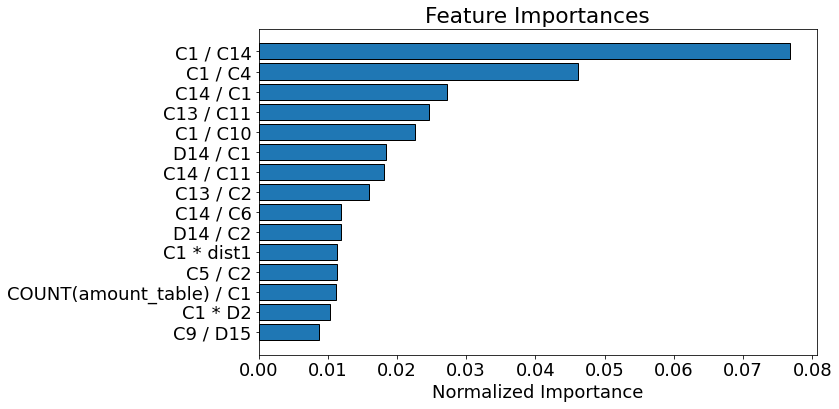

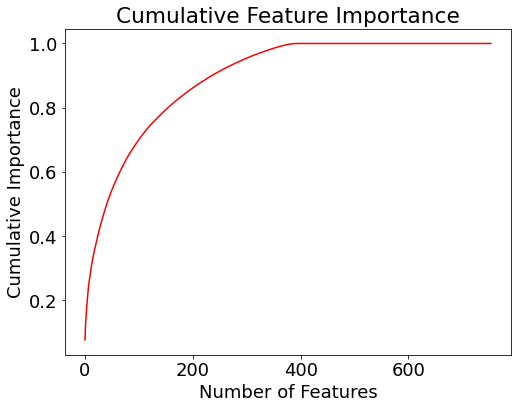

237 features required for 0.90 of cumulative importance


In [ ]:
# Plot features to keep
norm_feature_importances = plot_feature_importances(feature_importances)

In [ ]:
# Drop all zero important features
train_X = train_X.drop(columns = zero_features)
test_X = test_X.drop(columns = zero_features)

print('Training shape: ', train_X.shape)
print('Testing shape: ', test_X.shape)

In [ ]:
# Run the second important calculation to only keep the variabels wich explain 98% for the variation
second_round_zero_features, feature_importances = identify_zero_importance_features(train_X, train_y)

In [ ]:
# Plot the features to keep
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.98

In [ ]:
# Threshold for cumulative importance
threshold = 0.98

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_X = train_X[features_to_keep]
test_X = test_X[features_to_keep]

In [ ]:
# Reduce memory
memory_reducer(train_X)
memory_reducer(test_X)

### 3 Model


#### ** PICKEL **

In [ ]:
# CLEAN DATA FOR MODELLING
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_X_ftool.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_X_ftool.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_y_ftool.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_y_ftool.pkl')

In [ ]:
memory_reducer(train_X)
memory_reducer(test_X)

Mem. usage decreased to 292.86 Mb (6.3% reduction)
Mem. usage decreased to 72.09 Mb (6.4% reduction)


#### 3.1 SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=42, sampling_strategy = 1)
X_train_new, y_train_new = sm.fit_sample(train_X, train_y)

X = pd.DataFrame(X_train_new)
X.columns = train_X.columns
y = pd.DataFrame(y_train_new)

print('After OverSampling, the shape of X_train_new: {}'.format(X.shape))
print('After OverSampling, the shape of y_train_new: {} \n'.format(y.shape))

Before OverSampling, counts of label '1': 16600
Before OverSampling, counts of label '0': 455832 

After OverSampling, the shape of X_train_new: (911664, 306)
After OverSampling, the shape of y_train_new: (911664, 1) 



Text(0.5, 1.0, 'Target variable count')

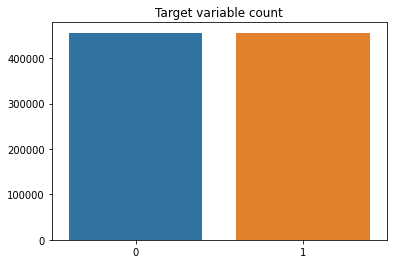

In [ ]:
# Check class after SMOTE
x=y.value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

#### 3.2 XGB

In [ ]:
# Tuned most important parameters for XGB based on baseline dataset
best_params = {
 'n_estimators': 350,
 'colsample_bytree': 0.5776,
 'gamma': 0.1284,
 'learning_rate': 0.159,
 'max_depth': 17,
 'min_child_weight': 0.9205}

[0]	validation_0-auc:0.811733
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.917373
[200]	validation_0-auc:0.918013
[300]	validation_0-auc:0.918119
[349]	validation_0-auc:0.918038


[Text(0.5, 1.0, 'Confusion Matrix')]

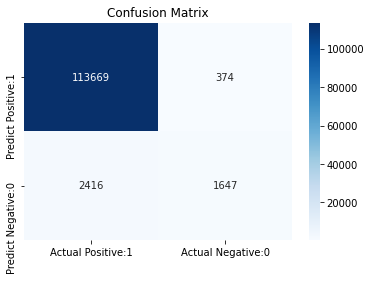

In [ ]:
# XGB with Early stopping

xgb = XGBClassifier(**best_params, tree_method='gpu_hist', reg_alpha=0.5)

evaluation_set = [(test_X, test_y)]

xgb.fit(X, y, early_stopping_rounds=200, eval_metric="auc", eval_set=evaluation_set, verbose=100)

# Predict on test data
y_pred = xgb.predict(test_X)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues').set(title='Confusion Matrix')

In [ ]:
# Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(test_y, y_pred) 

0.5650742289709588

In [ ]:
# Change in FP and TP comared to baseline
DeltaFP = (374 - 2387)
DeltaTP = (1647 - 1842)
print("Delta change in FP:", DeltaFP)
print("Delta change in TP:", DeltaTP)

Delta change in FP: -2013
Delta change in TP: -195


In [ ]:
FPR = (374/(113669+374))*100
TPR = (1647/(2416+1647))*100
print('True positive rate:', TPR),
print('False positive rate:', FPR)

True positive rate: 40.536549347772585
False positive rate: 0.32794647632910395


In [ ]:
# create the predicted class
y_pred = xgb.fit(X, y).predict_proba(test_X)[:,1]

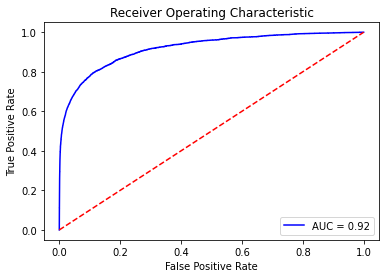

In [ ]:
# Build roc curve
buildROC(test_y, y_pred)

In [ ]:
#XGB
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

x = train_X.copy()
y = train_y.copy()

random_state = np.random.RandomState(0)
clf = XGBClassifier(**best_params, tree_method='gpu_hist')
cv = TimeSeriesSplit(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5-fold CV with ROC')
plt.legend(loc="lower right")
plt.show()

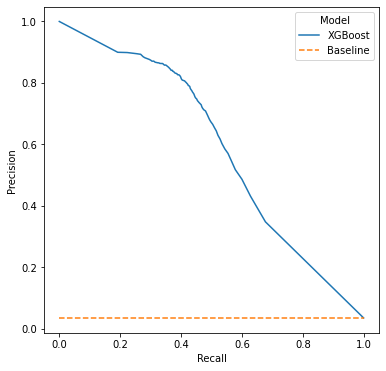

In [ ]:
# XGB

# Containers for true positive / false positive rates
xgb_precision_scores = []
xgb_recall_scores = []

xgb= XGBClassifier(**best_params, tree_method='gpu_hist')

y_test_probs = xgb.fit(X, y).predict_proba(test_X)[:,1]

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(test_y, y_test_preds)
        
    xgb_precision_scores.append(precision)
    xgb_recall_scores.append(recall)

# Plot precision-recall curve

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(xgb_recall_scores, xgb_precision_scores, label='XGBoost')
baseline = len(test_y[test_y==1]) / len(test_y)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc=1, title= "Model");

##### Features importance

In [ ]:
# Weight importance
feature_importance = xgb.get_booster().get_score(importance_type= "weight")
feature_importance_weight = pd.DataFrame(list(feature_importance.items()))
feature_importance_weight.columns = ['Feature', 'Importance']

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:25]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('XGBoost top 25 features')
    plt.tight_layout()

Feature       object
Importance     int64
dtype: object


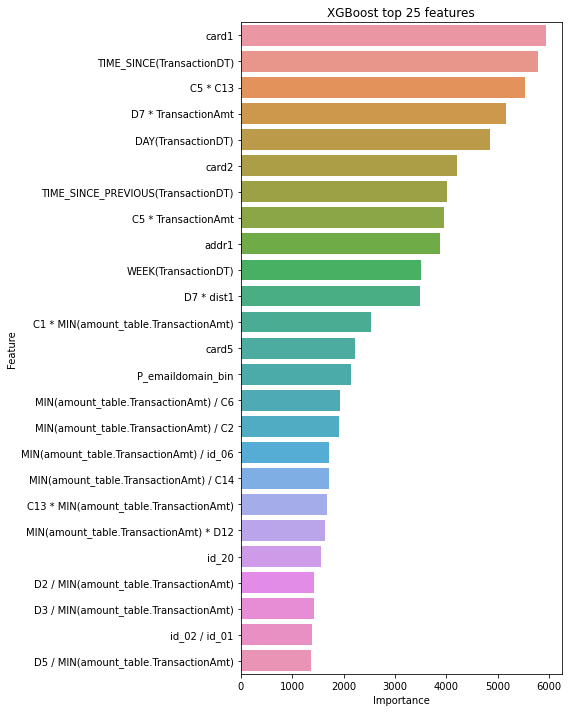

In [ ]:
display_importances(feature_importance_weight)

#### 3.3 Additional comparison calculations

##### Comparison Precision/Recall

In [ ]:
# CLEAN DATA FOR MODELING
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_X_manual.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_X_manual.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_y_manual.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_y_manual.pkl')

In [ ]:
# CLEAN DATA FOR MODELING
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/P/X_train_baseline.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/P/X_test_baseline.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/P/y_train_baseline.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/P/y_test_baseline.pkl')

In [ ]:
# XGB - Baseline

# Containers for true positive / false positive rates
base_precision_scores = []
base_recall_scores = []

xgb= XGBClassifier(**best_params, tree_method='gpu_hist')

y_test_probs = xgb.fit(X, y).predict_proba(test_X)[:,1]

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(test_y, y_test_preds)
        
    base_precision_scores.append(precision)
    base_recall_scores.append(recall)

In [ ]:
# XGB - Manual

# Containers for true positive / false positive rates
man_precision_scores = []
man_recall_scores = []

xgb= XGBClassifier(**best_params, tree_method='gpu_hist')

y_test_probs = xgb.fit(X, y).predict_proba(test_X)[:,1]

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(test_y, y_test_preds)
        
    man_precision_scores.append(precision)
    man_recall_scores.append(recall)

In [ ]:
# XGB

# Containers for true positive / false positive rates
ftool_precision_scores = []
ftool_recall_scores = []

xgb= XGBClassifier(**best_params, tree_method='gpu_hist')

y_test_probs = xgb.fit(X, y).predict_proba(test_X)[:,1]

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(test_y, y_test_preds)
        
    ftool_precision_scores.append(precision)
    ftool_recall_scores.append(recall)

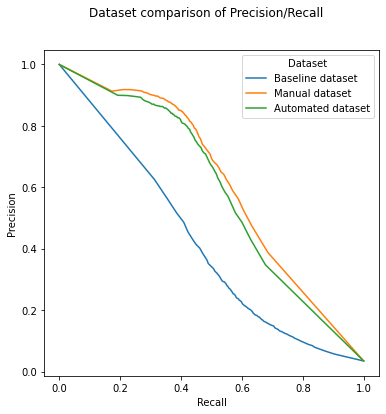

In [ ]:
# Plot precision-recall curve

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(base_recall_scores, base_precision_scores, label='Baseline dataset')
ax.plot(man_recall_scores, man_precision_scores, label='Manual dataset')
ax.plot(ftool_recall_scores, ftool_precision_scores, label='Automated dataset')
baseline = len(test_y[test_y==1]) / len(test_y)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
fig.suptitle("Dataset comparison of Precision/Recall")
ax.legend(loc=1, title= "Dataset");

##### Comparison ROC Curve

In [ ]:
# CLEAN DATA FOR MODELLING (FTOOL)
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_X_ftool.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_X_ftool.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_y_ftool.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_y_ftool.pkl')

In [ ]:
# CLEAN DATA FOR MODELING (BASELINE)
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/P/X_train_baseline.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/P/X_test_baseline.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/P/y_train_baseline.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/P/y_test_baseline.pkl')

In [ ]:
# CLEAN DATA FOR MODELING (MANUAL)
train_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_X_manual.pkl')
test_X = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_X_manual.pkl')
train_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/train_y_manual.pkl')
test_y = pd.read_pickle('/content/drive/MyDrive/Thesis/dataset/test_y_manual.pkl')

In [ ]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=42, sampling_strategy = 1)
X_train_new, y_train_new = sm.fit_sample(train_X, train_y)

X = pd.DataFrame(X_train_new)
X.columns = train_X.columns
y = pd.DataFrame(y_train_new)

print('After OverSampling, the shape of X_train_new: {}'.format(X.shape))
print('After OverSampling, the shape of y_train_new: {} \n'.format(y.shape))

Before OverSampling, counts of label '1': 16600
Before OverSampling, counts of label '0': 455832 

After OverSampling, the shape of X_train_new: (911664, 124)
After OverSampling, the shape of y_train_new: (911664, 1) 



In [ ]:
# Baseline


y_pred_prob3 = xgb.predict_proba(test_X)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(test_y, y_pred_prob3)

In [ ]:
# Manual

y_pred_prob2 = xgb.predict_proba(test_X)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(test_y, y_pred_prob2)

In [ ]:
# Feature tool

y_pred_prob1 = xgb.predict_proba(test_X)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(test_y, y_pred_prob1)

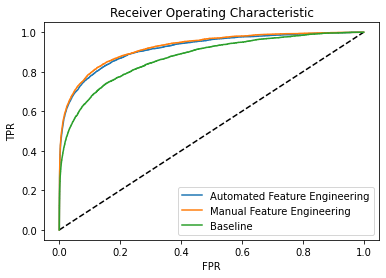

In [ ]:
#ROC Curve COMPARISON
from sklearn.metrics import roc_curve

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Automated Feature Engineering")
plt.plot(fpr2, tpr2, label= "Manual Feature Engineering")
plt.plot(fpr3, tpr3, label= "Baseline")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()